# Cell 1 — imports & config

In [1]:
# Cell 1: Imports & config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# Paths
DATA_PATH = "../data/sentiment/sentiment_results.csv"  # adjust if needed
FIG_DIR = "../outputs/figures"
TABLE_DIR = "../outputs/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)


# Cell 2 — load data & quick checks

In [2]:
# Cell 2: Load CSV and quick overview
df = pd.read_csv(DATA_PATH, parse_dates=["review_date"], dayfirst=False)
print("Rows:", len(df))
display(df.head())

# Ensure required cols exist
required = ["review_id","review_text","rating","review_date","bank_code","bank_name","sentiment_score","sentiment_label"]
for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")


Rows: 1463


,review_id,review_text,rating,review_date,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_score,sentiment_label
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play,0.0000,neutral
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play,0.4927,positive
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play,0.0000,neutral
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play,0.4926,positive
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,0.4404,positive


# Cell 3 — basic aggregates per bank

In [3]:
# Cell 3: Aggregates per bank
agg = df.groupby("bank_name").agg(
    total_reviews=("review_id","count"),
    avg_rating=("rating","mean"),
    median_rating=("rating","median"),
    avg_sentiment=("sentiment_score","mean"),
    positive_pct=("sentiment_label", lambda s: (s=="positive").mean()*100),
    negative_pct=("sentiment_label", lambda s: (s=="negative").mean()*100)
).reset_index()

agg = agg.sort_values("total_reviews", ascending=False)
display(agg)
agg.to_csv(os.path.join(TABLE_DIR,"bank_aggregates.csv"), index=False)


,bank_name,total_reviews,avg_rating,median_rating,avg_sentiment,positive_pct,negative_pct
1,Commercial Bank of Ethiopia,489,4.087935,5.0,0.278092,61.349693,7.975460
0,Bank of Abyssinia,487,3.308008,4.0,0.133056,48.049281,20.328542
2,Dashen Bank,487,4.121150,5.0,0.366332,69.404517,10.266940


# Cell 4 — sentiment trend time series (weekly)

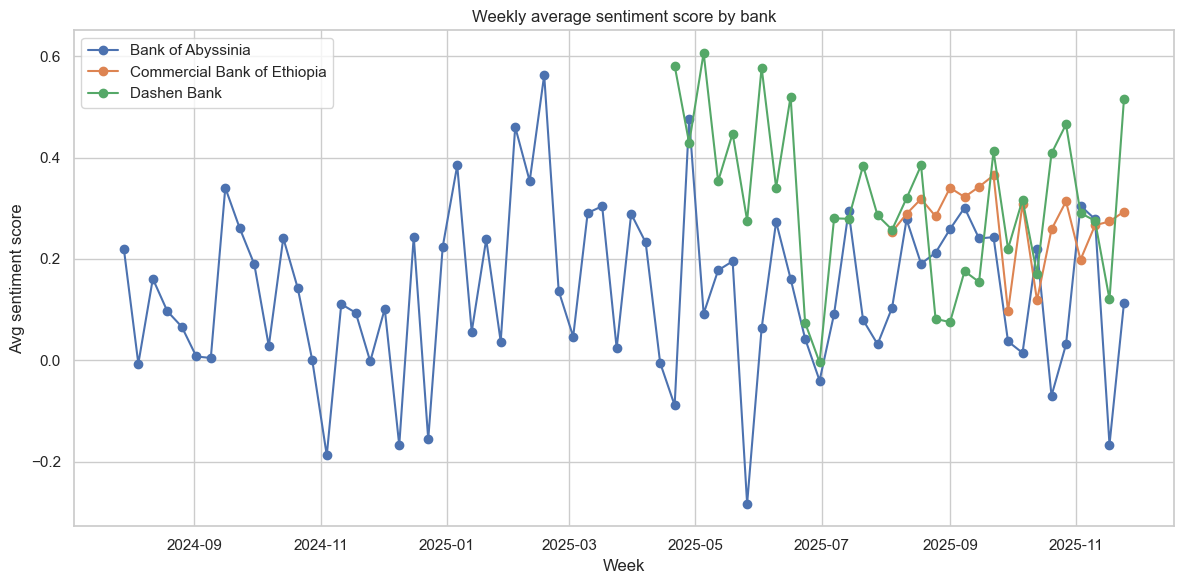

In [4]:
# Cell 4: Sentiment trend per bank (weekly average)
df["week"] = df["review_date"].dt.to_period("W").apply(lambda r: r.start_time)
trend = df.groupby(["bank_name","week"]).sentiment_score.mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
for bank, group in trend.groupby("bank_name"):
    plt.plot(group["week"], group["sentiment_score"], marker="o", label=bank)
plt.title("Weekly average sentiment score by bank")
plt.xlabel("Week")
plt.ylabel("Avg sentiment score")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"sentiment_trend_weekly.png"))
plt.show()


# Cell 5 — rating distribution (violin + counts)

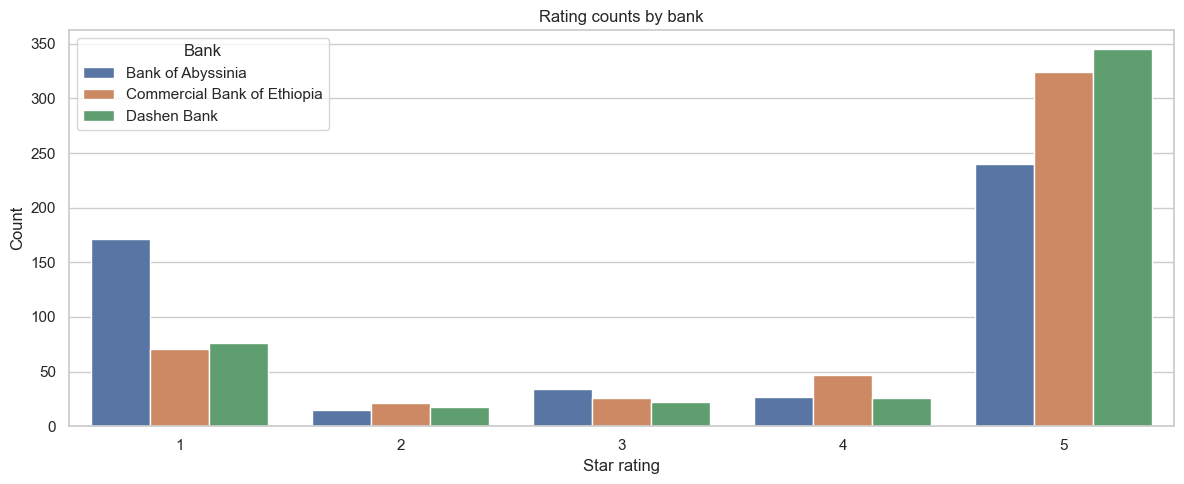

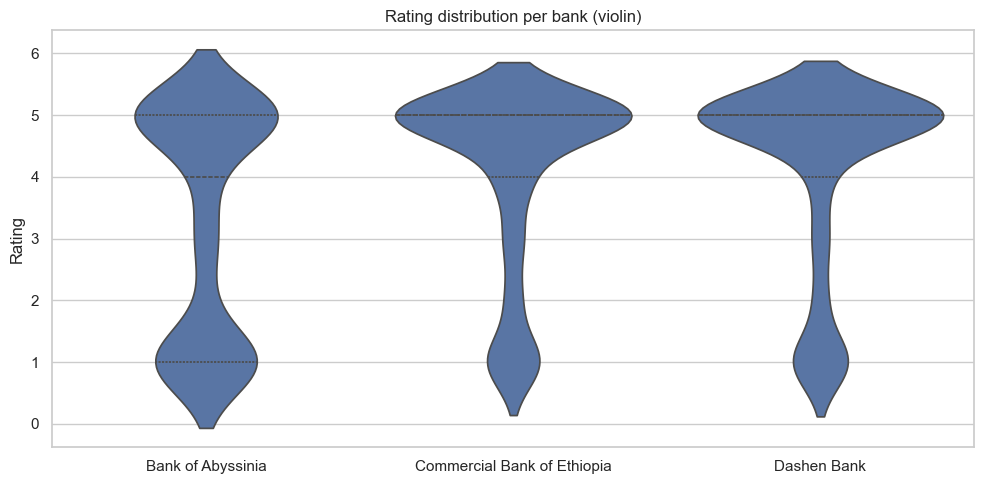

In [5]:
# Cell 5: Rating distribution per bank
plt.figure(figsize=(12,5))
sns.countplot(data=df, x="rating", hue="bank_name", order=sorted(df["rating"].unique()))
plt.title("Rating counts by bank")
plt.xlabel("Star rating")
plt.ylabel("Count")
plt.legend(title="Bank")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"rating_counts_by_bank.png"))
plt.show()

# Violin for more nuance
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x="bank_name", y="rating", inner="quartile")
plt.title("Rating distribution per bank (violin)")
plt.ylabel("Rating")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"rating_violin_by_bank.png"))
plt.show()


# Cell 6 — sentiment label breakdown (bar)

sentiment_label,negative,neutral,positive
bank_name,,,
Bank of Abyssinia,99,154,234
Commercial Bank of Ethiopia,39,150,300
Dashen Bank,50,99,338


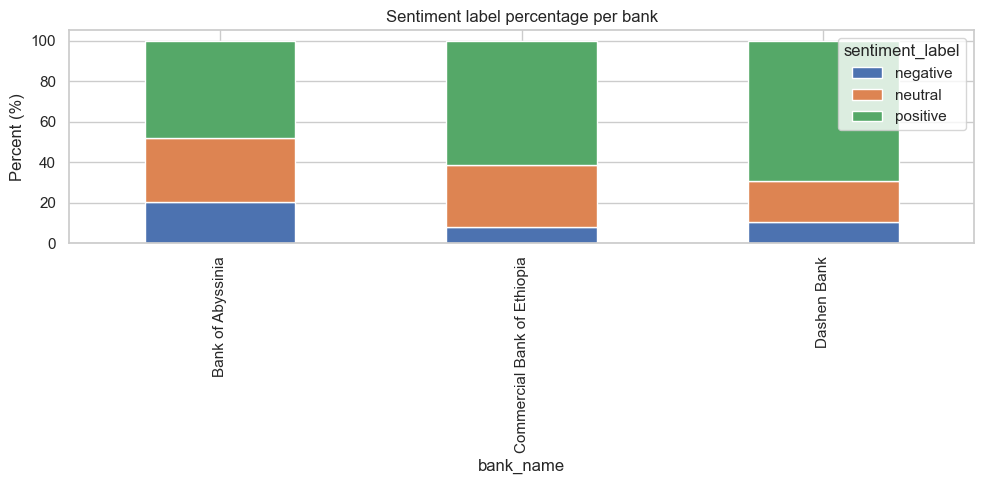

In [6]:
# Cell 6: Sentiment label distribution per bank
label_counts = (df.groupby(["bank_name","sentiment_label"])
                .review_id.count()
                .reset_index()
                .pivot(index="bank_name", columns="sentiment_label", values="review_id")
                .fillna(0))
label_counts_pct = label_counts.div(label_counts.sum(axis=1), axis=0)*100
display(label_counts)
label_counts_pct.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Sentiment label percentage per bank")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"sentiment_label_pct_by_bank.png"))
plt.show()


# Cell 7 — TF-IDF top keywords per bank (function + run)

In [7]:
# Cell 7: TF-IDF top keywords per bank
def get_top_tfidf_keywords(texts, n=20, ngram_range=(1,2), max_features=2000):
    vec = TfidfVectorizer(stop_words="english", ngram_range=ngram_range, max_features=max_features)
    X = vec.fit_transform(texts)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    top_idx = np.argsort(sums)[::-1][:n]
    return list(zip(terms[top_idx], sums[top_idx]))

tfidf_results = []
for bank, group in df.groupby("bank_name"):
    texts = group["review_text"].astype(str).tolist()
    if len(texts) < 10:
        continue
    top = get_top_tfidf_keywords(texts, n=25)
    for term, score in top:
        tfidf_results.append({"bank_name": bank, "keyword": term, "score": float(score)})

tfidf_df = pd.DataFrame(tfidf_results)
tfidf_df.to_csv(os.path.join(TABLE_DIR,"tfidf_keywords_by_bank.csv"), index=False)
tfidf_df.groupby("bank_name").head(10)


,bank_name,keyword,score
0,Bank of Abyssinia,good,55.725689
1,Bank of Abyssinia,app,28.307486
2,Bank of Abyssinia,best,18.352393
3,Bank of Abyssinia,nice,12.465593
4,Bank of Abyssinia,boa,10.342606
5,Bank of Abyssinia,working,8.584540
6,Bank of Abyssinia,bank,8.325766
7,Bank of Abyssinia,great,8.294800
8,Bank of Abyssinia,like,7.502694
9,Bank of Abyssinia,work,7.117611


# Cell 8 — plot top keywords (per bank, horizontal bar)

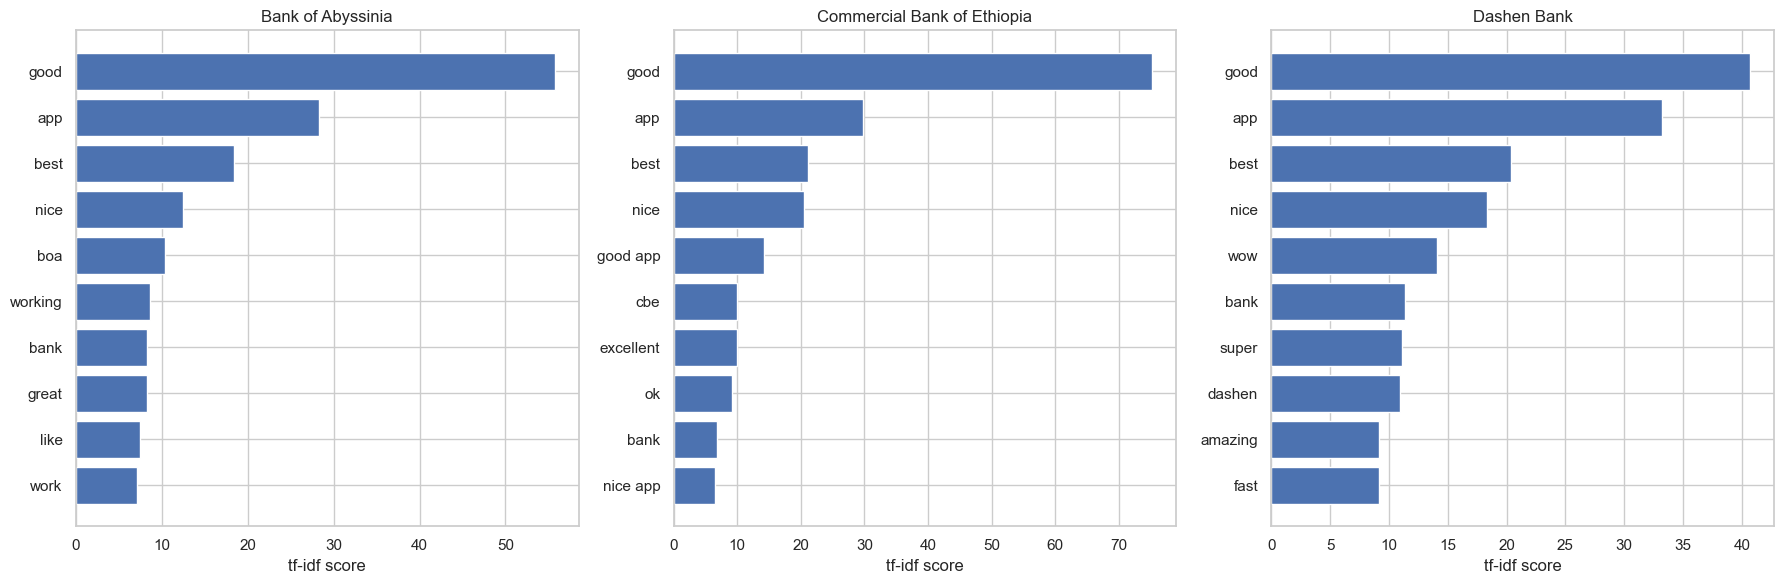

In [8]:
# Cell 8: Plot top keywords for each bank (top 10)
import math
banks = tfidf_df["bank_name"].unique()
n = len(banks)
fig, axes = plt.subplots(1, n, figsize=(6*n,6))
if n == 1:
    axes = [axes]

for ax, bank in zip(axes, banks):
    d = tfidf_df[tfidf_df["bank_name"]==bank].nlargest(10, "score").iloc[::-1]
    ax.barh(d["keyword"], d["score"])
    ax.set_title(bank)
    ax.set_xlabel("tf-idf score")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"top_keywords_by_bank.png"))
plt.show()


# Cell 9 — wordclouds per bank

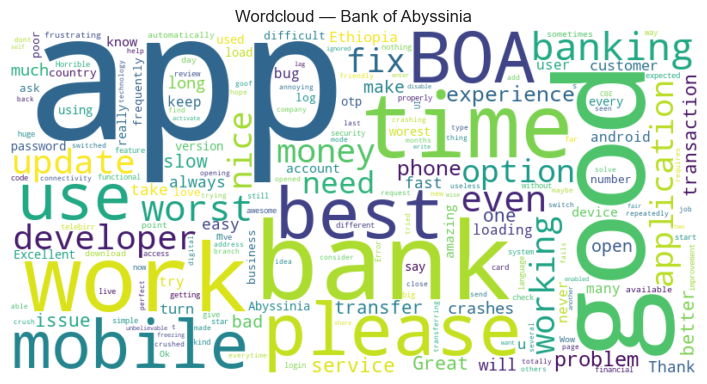

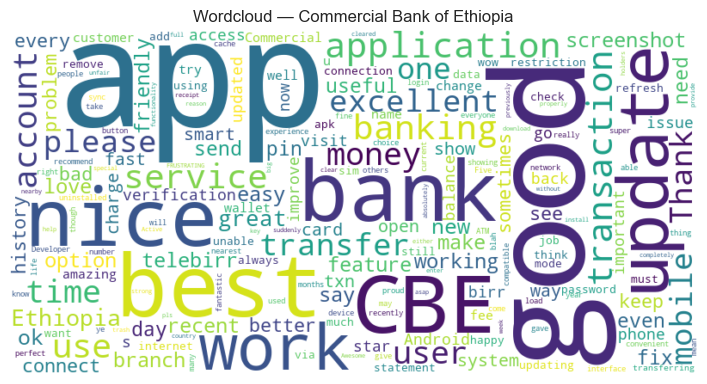

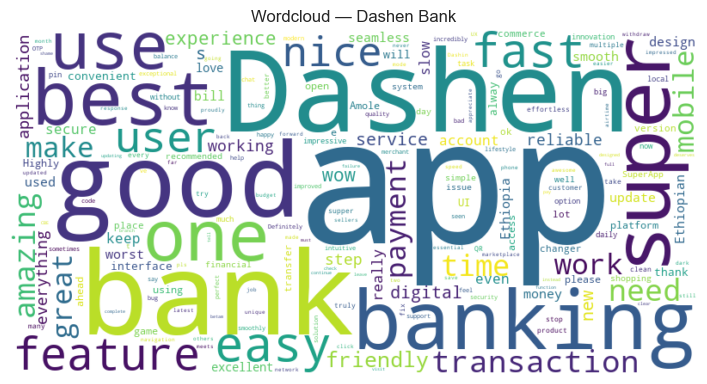

In [9]:
# Cell 9: Wordclouds per bank
for bank, group in df.groupby("bank_name"):
    text = " ".join(group["review_text"].astype(str).tolist())
    if len(text.strip()) < 10: 
        continue
    wc = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud — {bank}")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"wordcloud_{bank.replace(' ','_')}.png"))
    plt.show()


# Cell 10 — extract drivers & pain points (rule-based + examples)

In [10]:
# Cell 10: Simple rule-based drivers/pain extraction
# Define keyword groups for drivers and pains (tweak these)
DRIVERS = {
    "Speed/Performance": ["fast", "speed", "quick", "loading", "fastly", "lag", "slow"],
    "UI/UX": ["easy", "user friendly", "ui", "interface", "design", "intuitive"],
    "Feature": ["transfer", "login", "biometric", "fingerprint", "scan", "payment"]
}
PAINS = {
    "Crashes/Errors": ["crash", "crashed", "error", "bug", "issue", "stopped", "fail"],
    "Connectivity": ["connect", "connection", "network", "offline"],
    "Slow/lag": ["slow", "lag", "loading", "hang"]
}

def count_keywords(group_texts, keywords):
    cnt = 0
    examples = []
    for t in group_texts:
        lower = t.lower()
        for k in keywords:
            if k in lower:
                cnt += 1
                if len(examples) < 3:
                    examples.append(t)
                break
    return cnt, examples

summary = []
for bank, group in df.groupby("bank_name"):
    texts = group["review_text"].astype(str).tolist()
    row = {"bank": bank}
    # drivers
    for name, kws in DRIVERS.items():
        cnt, ex = count_keywords(texts, kws)
        row[f"driver_{name}"] = cnt
        row[f"driver_{name}_examples"] = ex
    # pains
    for name, kws in PAINS.items():
        cnt, ex = count_keywords(texts, kws)
        row[f"pain_{name}"] = cnt
        row[f"pain_{name}_examples"] = ex
    summary.append(row)

summary_df = pd.DataFrame(summary)
display(summary_df.T)
summary_df.to_csv(os.path.join(TABLE_DIR,"drivers_pains_summary.csv"), index=False)


,0,1,2
bank,Bank of Abyssinia,Commercial Bank of Ethiopia,Dashen Bank
driver_Speed/Performance,39,11,61
driver_Speed/Performance_examples,[not user friendly at all it requires a huge c...,"[very good banking service and fast service, f...",[its fast and easy to communicate to the app a...
driver_UI/UX,23,17,71
driver_UI/UX_examples,[not user friendly at all it requires a huge c...,"[Make it user friendly., make life easy, The a...","[very smart App easy to use and friendly, its ..."
driver_Feature,16,18,27
driver_Feature_examples,[It does not show the name of the person who s...,[This application is very important and advant...,[The Dashen Super App is very impressive. It i...
pain_Crashes/Errors,34,10,22
pain_Crashes/Errors_examples,[I would like to share feedback regarding the ...,[CBE needs to show transaction fees before the...,[What do you care about my phone's settings? W...
pain_Connectivity,8,13,8


# Cell 11 — bank comparison table & export

In [11]:
# Cell 11: compare pairs (example CBE vs BOA)
pair = agg.set_index("bank_name")
display(pair)

# Export a short CSV for report
pair.to_csv(os.path.join(TABLE_DIR,"bank_comparison.csv"))


,total_reviews,avg_rating,median_rating,avg_sentiment,positive_pct,negative_pct
bank_name,,,,,,
Commercial Bank of Ethiopia,489,4.087935,5.0,0.278092,61.349693,7.975460
Bank of Abyssinia,487,3.308008,4.0,0.133056,48.049281,20.328542
Dashen Bank,487,4.121150,5.0,0.366332,69.404517,10.266940


# Cell 12 — export top negative reviews for stakeholder quotes

In [12]:
# Cell 12: Top negative reviews for each bank (useful in report)
neg_examples = (df[df["sentiment_label"]=="negative"]
                .sort_values("sentiment_score")
                .groupby("bank_name")
                .head(5)[["bank_name","rating","sentiment_score","review_text","review_date"]])

neg_examples.to_csv(os.path.join(TABLE_DIR,"top_negative_examples.csv"), index=False)
display(neg_examples)


,bank_name,rating,sentiment_score,review_text,review_date
422,Bank of Abyssinia,1,-0.9312,"Shockingly bad! Even when it decides to work, ...",2024-09-06
1005,Dashen Bank,1,-0.9205,NASTY BANK . EVEN THE SUPPER APP IS NOT WORKIN...,2025-11-10
45,Bank of Abyssinia,1,-0.9107,the worst bank ever. slow don't accept dual si...,2025-10-20
14,Bank of Abyssinia,1,-0.8834,I cant belive I could find the worst bank app ...,2025-11-18
415,Bank of Abyssinia,1,-0.8758,"It say ""The request was not successful. please...",2024-09-11
502,Commercial Bank of Ethiopia,1,-0.8746,it suddenly asked me to enter the verification...,2025-11-25
1043,Dashen Bank,1,-0.8735,This might be the worst banking app I've ever ...,2025-11-01
1279,Dashen Bank,1,-0.8681,Cannot list the number of bugs with this pile ...,2025-07-02
283,Bank of Abyssinia,1,-0.8587,"I will give only one star, because it faced wi...",2025-01-03
537,Commercial Bank of Ethiopia,1,-0.8466,"Seriously, what’s going on with this app? The ...",2025-11-15


# Cell 13 — short recommendations template & ethics note

In [13]:
# Cell 13: Recommendations & Ethical note (print / save as text)
recs = {
    "Commercial Bank of Ethiopia": [
        "Investigate slow transfer flows on high-load endpoints (evidence: 'slow', 'loading' counts)",
        "Improve onboarding UI elements; reduce clicks for frequent tasks"
    ],
    "Bank of Abyssinia": [
        "Stabilize app to reduce crashes (evidence: many 'crash' mentions)",
        "Optimize network handling for low-connectivity scenarios"
    ],
    "Dashen Bank": [
        "Add in-app help and clearer error messages for failed transactions",
        "Prioritize performance improvements for older devices"
    ]
}

print("Recommendations (short):")
for bank, items in recs.items():
    print(f"\n{bank}:")
    for i, r in enumerate(items,1):
        print(f" {i}. {r}")

ethics = """
Ethical notes:
- Reviews are self-selected (survivorship / negativity bias).
- May be skewed to recent events or specific user segments (power users).
- Language coverage: some reviews in Amharic were removed; this may bias results away from non-English voices.
- Use anonymized examples & avoid exposing PII in reports.
"""
print(ethics)

# Save as small text to outputs
with open(os.path.join(TABLE_DIR,"recommendations.txt"), "w", encoding="utf8") as f:
    f.write("Recommendations\n\n")
    for bank, items in recs.items():
        f.write(bank + ":\n")
        for r in items:
            f.write("- " + r + "\n")
        f.write("\n")
    f.write("\nEthics:\n")
    f.write(ethics)


Recommendations (short):

Commercial Bank of Ethiopia:
 1. Investigate slow transfer flows on high-load endpoints (evidence: 'slow', 'loading' counts)
 2. Improve onboarding UI elements; reduce clicks for frequent tasks

Bank of Abyssinia:
 1. Stabilize app to reduce crashes (evidence: many 'crash' mentions)
 2. Optimize network handling for low-connectivity scenarios

Dashen Bank:
 1. Add in-app help and clearer error messages for failed transactions
 2. Prioritize performance improvements for older devices

Ethical notes:
- Reviews are self-selected (survivorship / negativity bias).
- May be skewed to recent events or specific user segments (power users).
- Language coverage: some reviews in Amharic were removed; this may bias results away from non-English voices.
- Use anonymized examples & avoid exposing PII in reports.



# Cell 14 — save figures and brief report export

In [15]:
# Cell 14: Save any remaining figures (if not already saved) and create a small HTML or markdown summary
# (We already saved plotted PNGs above). Create a quick markdown summary to use in final report.
md = "# Task 4 — Insights Summary\n\n"
md += "See outputs/figures and outputs/tables for visuals and tables.\n\n"
md += "Top findings:\n"
for i, r in summary_df.iterrows():
    md += f"- {r['bank']}: drivers & pain counts saved in outputs/tables/drivers_pains_summary.csv\n"

with open("../reports/task4_summary.md", "w", encoding="utf8") as f:
    f.write(md)

print("Saved summary to reports/task4_summary.md")


Saved summary to reports/task4_summary.md
